In [1]:
import json
import random
import uuid
import numpy as np
import time
import requests
import traceback
import math
import ast
import pandas as pd
import pdb
from tqdm.auto import tqdm
tqdm.pandas()

# Functions

In [2]:
def convert_df_to_json_set_SINGLE(df):
    microtask_jsons = []
    padding = 100
    try:
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            for idy, evidence in enumerate(row['nlp_sentences_all_TOP_N']):
                
                # Let us retrieve the sections before and after the evidence. 100 characters to each side will do.
                all_sentences = row['nlp_sentences']    
                
                evidence_idx = evidence['sentence_id']
                if ';' in evidence_idx:
                    before_idx = int(evidence_idx.split(';')[0])-1
                    after_idx = int(evidence_idx.split(';')[1])+1
                else:                    
                    before_idx = int(evidence_idx)-1
                    after_idx = int(evidence_idx)+1
                    
                pre_evidence = []
                for i in range(before_idx,-1,-1):
                    pre_evidence.insert(0, all_sentences[i])
                    if len(' '.join(pre_evidence))>=100:
                        break
                pre_evidence = ' '.join(pre_evidence)
                
                post_evidence = []
                for i in range(after_idx,len(all_sentences)):
                    post_evidence.append(all_sentences[i])
                    if len(' '.join(post_evidence))>=100:
                        break
                post_evidence = ' '.join(post_evidence)
                
                assert ' '.join([pre_evidence, evidence['sentence'], post_evidence]).strip() in ' '.join(all_sentences)
                
                microtask_json = {
                    "claim_id": row['claim_id'],
                    "reference_id": row['reference_id'],
                    "evidence_id": idy,
                    "sentence_id": evidence_idx,
                    "score": evidence['score'],
                    "affirmation": row['final_verbalisation'],
                    "pre_evidence": pre_evidence,
                    "evidence": evidence['sentence'],
                    "post_evidence": post_evidence,
                    "reference_url": row['final_url'],
                    "g_id": -1
                }
                microtask_jsons.append(microtask_json)
                #raise ValueError
                
        return microtask_jsons
    except Exception:
        print(' '.join([pre_evidence, evidence['sentence'], post_evidence]))
        #print(pre_evidence)
        #print('--')
        #print(evidence['sentence'])
        #print('--')
        #print(post_evidence)
        print('--')
        print(' '.join(all_sentences))
        #print(row)
        #traceback.print_exc()
        #pdb.set_trace()
        raise
        
def convert_df_to_json_set_MULTIPLE(df):
    microtask_jsons = []
    padding = 100
    try:
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            evidence_list = []
            all_sentences = row['nlp_sentences']
            
            for idy, evidence in enumerate(row['nlp_sentences_all_TOP_N']):
                              
                evidence_idx = evidence['sentence_id']
                if ';' in evidence_idx:
                    before_idx = int(evidence_idx.split(';')[0])-1
                    after_idx = int(evidence_idx.split(';')[1])+1
                else:                    
                    before_idx = int(evidence_idx)-1
                    after_idx = int(evidence_idx)+1
                    
                pre_evidence = []
                for i in range(before_idx,-1,-1):
                    pre_evidence.insert(0, all_sentences[i])
                    if len(' '.join(pre_evidence))>=100:
                        break
                pre_evidence = ' '.join(pre_evidence)
                
                post_evidence = []
                for i in range(after_idx,len(all_sentences)):
                    post_evidence.append(all_sentences[i])
                    if len(' '.join(post_evidence))>=100:
                        break
                post_evidence = ' '.join(post_evidence)
                
                assert ' '.join([pre_evidence, evidence['sentence'], post_evidence]).strip() in ' '.join(all_sentences)
                
                evidence_list.append({
                    "evidence_id": idy,
                    "sentence_id": evidence_idx,
                    "score": evidence['score'],
                    "pre_evidence": pre_evidence,
                    "evidence": evidence['sentence'],
                    "post_evidence": post_evidence,
                })
            evidence_list_shuffle = random.Random(42).sample(evidence_list, len(evidence_list))    
            microtask_json = {
                "claim_id": row['claim_id'],
                "reference_id": row['reference_id'],
                "affirmation": row['final_verbalisation'],
                "reference_url": row['final_url'],
                "g_id": -1,
                "evidence_list": evidence_list_shuffle
            }
            microtask_jsons.append(microtask_json)
                
        return microtask_jsons
    except Exception:
        print(' '.join([pre_evidence, evidence['sentence'], post_evidence]))
        #print(pre_evidence)
        #print('--')
        #print(evidence['sentence'])
        #print('--')
        #print(post_evidence)
        print('--')
        print(' '.join(all_sentences))
        #print(row)
        #traceback.print_exc()
        #pdb.set_trace()
        raise

In [3]:
#maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
#maxSingleInstances_gd = 2

def getRandomTask(counter, n, non_gd_references, maxSingleInstances):
    p = [max(maxSingleInstances-c,0.0001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(non_gd_references))),
        size=n,
        replace=False,
        p=p
    )        
    task = []
    for i in indexes:
        reference = non_gd_references[i]
        task.append((reference,i))
    return task

def getRandomGoldenTask(counter, n, gd_references, maxSingleInstances_gd):    
    p = [max(maxSingleInstances_gd-c,0.0001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(gd_references))),
        size=n,
        replace=False,
        p=p
    )
    task = []
    for i in indexes:
        reference = gd_references[i]
        task.append((reference,i))
    return task

def generateTaskSet(counter, counter_gd, non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd, n=(4,2)):
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    task = getRandomTask(counter, n[0], non_gd_references, maxSingleInstances)
    taskSet += [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    task_gd = getRandomGoldenTask(counter_gd, n[1], gd_references, maxSingleInstances_gd)
    taskSet += [r for (r,i) in task_gd]
    taskSet_shuffle = random.Random(42).sample(taskSet, len(taskSet))
    return taskSet_shuffle, [i for (p,i) in task], [i for (p,i) in task_gd] # we return indices here to update counter


def generateIDdTaskSets(non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd):
    counter = [0]*len(non_gd_references)
    counter_gd = [0]*len(gd_references)
    taskSets = []
    while (any([c < maxSingleInstances for c in counter])):
        taskSet, indexes, indexes_gd = generateTaskSet(counter, counter_gd, non_gd_references,
                                                       gd_references, maxSingleInstances, maxSingleInstances_gd)
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd)
        for i in indexes:
            counter[i] = counter[i] + 1
        for i in indexes_gd:
            counter_gd[i] = counter_gd[i] + 1
    return taskSets, counter, counter_gd

# Data

In [4]:
data_df = pd.read_json('../data/textual_entailment_df.json')
data_df = data_df.drop([c for c in data_df.columns if 'TOP_N' in c and 'all_TOP_N' not in c], axis=1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           1302 non-null   object 
 1   claim_id                               1302 non-null   object 
 2   final_verbalisation                    1302 non-null   object 
 3   sampling_weight                        1302 non-null   float64
 4   final_url                              1302 non-null   object 
 5   netloc_agg                             1302 non-null   object 
 6   nlp_sentences                          1302 non-null   object 
 7   nlp_sentences_slide_2                  1302 non-null   object 
 8   nlp_sentences_scores                   1302 non-null   object 
 9   nlp_sentences_slide_2_scores           1302 non-null   object 
 10  nlp_sentences_all_TOP_N                1302 non-null   object 
 11  evid

Estimated cost of running **single evidence** tasks for all 1302 verbalisations, paying 0.5 per task is:

In [5]:
((1302*5)-45)/4*5*0.5*1.2

4848.75

Which is a lot, so we will cut this down by:
- Restricting only a single random claim per reference_id, returning the balance to referenced websites
- Removing the lowest scoring websites according to netloc_agg.

In [6]:
data_df_trim = data_df.sample(frac=1, random_state=42).drop_duplicates('reference_id').sort_index().reset_index(drop=True)
data_df_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           648 non-null    object 
 1   claim_id                               648 non-null    object 
 2   final_verbalisation                    648 non-null    object 
 3   sampling_weight                        648 non-null    float64
 4   final_url                              648 non-null    object 
 5   netloc_agg                             648 non-null    object 
 6   nlp_sentences                          648 non-null    object 
 7   nlp_sentences_slide_2                  648 non-null    object 
 8   nlp_sentences_scores                   648 non-null    object 
 9   nlp_sentences_slide_2_scores           648 non-null    object 
 10  nlp_sentences_all_TOP_N                648 non-null    object 
 11  eviden

According to previous analysis, these are the worst-performing netloc_agg values in terms of evidence scoring:
- witches.shca.ed.ac.uk
- en.isabart.org
- bechdeltest.com
- npg.si.edu
- www.guidetopharmacology.org
- letterboxd.com
- www.discogs.com
- www.nytimes.com
- vocab.getty.edu
- www.isfdb.org

In [7]:
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]

assert all([b in data_df_trim.netloc_agg.unique() for b in bad_netloc_aggs])

In [8]:
data_df_trim_good = data_df_trim[~data_df_trim.netloc_agg.isin(bad_netloc_aggs)].reset_index(drop=True)
data_df_trim_good

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,nlp_sentences_all_TOP_N,evidence_TE_prob_all_TOP_N,evidence_TE_prob_weighted_all_TOP_N,evidence_TE_labels_all_TOP_N,claim_TE_prob_weighted_sum_all_TOP_N,claim_TE_label_weighted_sum_all_TOP_N,claim_TE_label_malon_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",[{'sentence': 'He died in an air crash near Ku...,"[[0.9708649516000001, 0.0061447304, 0.02299031...","[[0.9707732797, 0.0061441502, 0.0229881462], [...","[SUPPORTS, SUPPORTS, NOT ENOUGH INFO, NOT ENOU...","[1.9523134232000001, 0.0484717116, 2.5008661747]",NOT ENOUGH INFO,SUPPORTS
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...","[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M...","[[0.09385417400000001, 0.2980020344, 0.6081437...","[[0.0830457285, 0.2636834979, 0.5381085873], [...","[NOT ENOUGH INFO, NOT ENOUGH INFO, NOT ENOUGH ...","[0.1000050157, 0.4289829731, 0.8527254462]",NOT ENOUGH INFO,SUPPORTS
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",[{'sentence': 'AWB was formed in early 1972 in...,"[[0.9388607144000001, 0.0051775482, 0.05596167...","[[0.9337435365000001, 0.0051493281, 0.05565666...","[SUPPORTS, REFUTES, NOT ENOUGH INFO, NOT ENOUG...","[0.964186728, 0.8969765306, 0.25956323740000004]",SUPPORTS,SUPPORTS
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[[0.7398596406, 0.0883401632, 0.17180021110000...","[[0.7397438288, 0.088326335, 0.1717733145], [0...","[SUPPORTS, NOT ENOUGH INFO, REFUTES, NOT ENOUG...","[0.7442157269, 0.3141435385, 0.5475053787]",SUPPORTS,SUPPORTS
4,1ee71b39caf6df395c64b436fea4895692812d38,Q5289513$B0532490-8FEC-4744-9D74-61238B633898,Dolores Delirio started work in 1994.,24749.538462,https://en.wikipedia.org/w/index.php?title=Dol...,en.wikipedia.org,"[Dolores Delirio., From Wikipedia, the free en...","[Dolores Delirio. From Wikipedia, the free enc...","[-0.49935883280000004, -0.9997779727, -0.99969...","[-0.9781491756, -0.9995777011, -0.9996224642, ...",[{'sentence': 'Dolores Delirio is a Peruvian r...,"[[0.7100448608000001, 0.0457550883, 0.24419999...","[[0.7099757195, 0.0457506366, 0.24417622390000...","[SUPPORTS, NOT ENOUGH INFO, NOT ENOUGH INFO, N...","[0.7102969885, 0.0495032594, 0.2685163021]",SUPPORTS,SUPPORTS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,e004706cba4821386dc31a86faeb680e8fff4ae7,Q58480207$B8B66EE1-CD20-4426-846C-4B37DC5

In [9]:
#Now the costs are:
((data_df_trim_good.shape[0]*5)-45)/4*5*0.5*1.2
# Which are much more manageable

1500.0

In [10]:
# Whereas for the *multiple evidence* task paying $1 each, they are:
(data_df_trim_good.shape[0]-45)/4*5*1*1.2

# For a total of 1787.5, which is A-ok

546.0

In [11]:
task_data = data_df_trim_good

# PILOT

If we select 20 entries that means:

- For the **single evidence** task, we will have 20\*5 = 100 subtasks
    - Taking 8 as golden data means (100-8)/4 = **23** tasks.
    - Giving \\$0.5 per task, giving them for 5 annotators, with 20\% to Amazon, means 23\*5\*0.5\*1.2 = \\$69.
- For the **multiple evidence** task, we will have 20 subtasks
    - Taking 4 as golden data means (20-4)/4 = **4** tasks.
    - Giving \\$1 per task, giving them for 5 annotators, with 20\% to Amazon, means 4\*5\*1\*1.2 = \\$24.
    
Total Pilot cost = $93

In [12]:
task_data_pilot= task_data.sample(20, random_state=42)
task_data_pilot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 172 to 77
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           20 non-null     object 
 1   claim_id                               20 non-null     object 
 2   final_verbalisation                    20 non-null     object 
 3   sampling_weight                        20 non-null     float64
 4   final_url                              20 non-null     object 
 5   netloc_agg                             20 non-null     object 
 6   nlp_sentences                          20 non-null     object 
 7   nlp_sentences_slide_2                  20 non-null     object 
 8   nlp_sentences_scores                   20 non-null     object 
 9   nlp_sentences_slide_2_scores           20 non-null     object 
 10  nlp_sentences_all_TOP_N                20 non-null     object 
 11  eviden

In [13]:
jsonsets_SINGLE_pilot = convert_df_to_json_set_SINGLE(task_data_pilot)
len(jsonsets_SINGLE_pilot), jsonsets_SINGLE_pilot[0]

  0%|          | 0/20 [00:00<?, ?it/s]

(100,
 {'claim_id': 'Q64566934$EA9C53AA-1E8D-4D0D-814E-0FB00E7AA3EE',
  'reference_id': 'c142c251fcb563f07dabef11a283b4fd171f1eb6',
  'evidence_id': 0,
  'sentence_id': '14',
  'score': 0.29895803330000004,
  'affirmation': 'Pandallur Hss is located in India.',
  'pre_evidence': 'PANDALLUR HSS was established in 1979 and it is managed by the Pvt. Aided. It is located in Rural area.',
  'evidence': 'It is located in MANJERI block of MALAPPURAM district of Kerala.',
  'post_evidence': "The school consists of Grades from 8 to 12. The school is Co-educational and it doesn't have an attached pre-primary section.",
  'reference_url': 'https://schools.org.in/malappuram/32050601215/',
  'g_id': -1})

In [14]:
jsonsets_MULTIPLE_pilot = convert_df_to_json_set_MULTIPLE(task_data_pilot)
len(jsonsets_MULTIPLE_pilot), jsonsets_MULTIPLE_pilot[10]

  0%|          | 0/20 [00:00<?, ?it/s]

(20,
 {'claim_id': 'Q100562234$6222DFB3-EC74-4C9D-B02D-BB70AFB981B9',
  'reference_id': '5e9bc44ce8b4ae04f57985660ab5f880cee53315',
  'affirmation': 'Merchant Shipping (Grain) Rules, 1953 has a citation of S.I. No. 348/1953.',
  'reference_url': 'https://www.irishstatutebook.ie/eli/1953/si/348/made/en/print',
  'g_id': -1,
  'evidence_list': [{'evidence_id': 0,
    'sentence_id': '47;48',
    'score': 0.9998652339,
    'pre_evidence': 'Advanced Search Cuardach Casta. Home Baile. Statutory Instruments Ionstraimí Reachtúla. 1953. S.I. No.',
    'evidence': '348/1953- Merchant Shipping (Grain) Rules, 1953. S.I.',
    'post_evidence': 'No. 348/1953- Merchant Shipping (Grain) Rules, 1953. View SI Amharc ar an IR. Amendments Leasuithe. S.I.'},
   {'evidence_id': 4,
    'sentence_id': '61;62',
    'score': 0.1842070073,
    'pre_evidence': "These Rules supersede all regulations made under section' 453 of the Merchant Shipping Act, 1894, before the coming into operation of these Rules which sa

## Separate Gold Standard

We now split the json sets into two, one with golden standards and one with references to be judged.

Here is we calculate an appropriate number of gold standards:
- Let X be the maximum expected number of tasks any singular worker can complete;
- Let Y be the number of gold standard references we have annotated;
- Let Z be the number of combinations of 2 gold standard references that we can take from the Y gold standard references in our gold set, regardless of pairing order, without repeating.
- Let P be the probability of a worker doing X tasks and not finding a repeated pair of golden standard references, taken from the set of Z gold standard pairs.

So we calculate:
- Z = Y*(Y-1)/2
- P = Z!/((Z^X)*(Z-X)!)

So, we set X = 15 (The mean number of tasks per worker for previous experiments has been 4, with standard deviation of 10.5, so if it follows a normal distribution, we get 85% of workers here).

According to the calculation below, we see that **Y = 45** gives us near 90% of chances of not having repeated gold standard, so that is how many gold standards we aim at annotating for each language

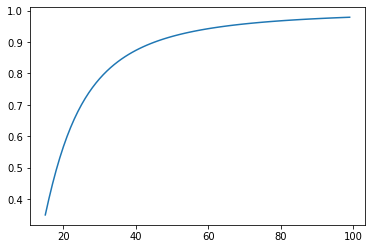

In [198]:
from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(15,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]
plt.plot(ys,ps)

In [17]:
golden_standard_quota_SINGLE_pilot = 8 #should be 45 for the campaign
golden_standard_quota_MULTIPLE_pilot = 4

jsonsets_SINGLE_pilot_shuffle = random.Random(42).sample(jsonsets_SINGLE_pilot, len(jsonsets_SINGLE_pilot))
#with open('../data/pilot/single_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_SINGLE_pilot_shuffle[:golden_standard_quota_SINGLE_pilot],
#        f, indent=2,ensure_ascii=False
#    )
with open('../data/pilot/single.json','w+',encoding='utf8') as f:
    json.dump(
        jsonsets_SINGLE_pilot_shuffle[golden_standard_quota_SINGLE_pilot:],
        f, indent=2,ensure_ascii=False
    )   
    
jsonsets_MULTIPLE_pilot_shuffle = random.Random(42).sample(jsonsets_MULTIPLE_pilot, len(jsonsets_MULTIPLE_pilot))
#with open('../data/pilot/multiple_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_MULTIPLE_pilot_shuffle[:golden_standard_quota_MULTIPLE_pilot],
#        f, indent=2,ensure_ascii=False
#    )
with open('../data/pilot/multiple.json','w+',encoding='utf8') as f:
    json.dump(
        jsonsets_MULTIPLE_pilot_shuffle[golden_standard_quota_MULTIPLE_pilot:],
        f, indent=2,ensure_ascii=False
    )  

You must now annotate the golden standard by doing the following:
For each gd reference in the gd json set, go to the "gd" field, which should be like this:
```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": -1
}
```

and change it to something of the format:

```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": [list of allowed values]
}
```
where by allowed values we mean any of the following which could apply to this case:
- 0: Supports
- 1: Refutes
- 2: Neither
- 3: Not Sure

If any golden data case is ambiguous, exchange it for a non-gd case and **save to a x_gd_2.json** file

## Generating Task Sets

**Make sure you have annotated the GD before proceeding here**

**Make sure you have also filtered the non-GD for API-verifiable examples**

Now we take 4 non_gd references and 2 gd references and pack them into task sets of 6

In [21]:
cost_single_task = 0.5
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 6 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS

print('Generating Task Sets [SINGLE]')
with open('../data/pilot/single_gd.json','r',encoding='utf8') as f:
    single_gd = json.load(f)
    print('Gd len:',len(single_gd))
with open('../data/pilot/single.json','r',encoding='utf8') as f:
    single = json.load(f)
    print('Non-Gd len:',len(single))

ds, c, c_gd = generateIDdTaskSets(single, single_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_single_task*1.2}')

with open('../data/pilot/single_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [SINGLE]
Gd len: 8
Non-Gd len: 92
Generated 23 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Each golden data appearance counter is: [6, 6, 6, 6, 6, 5, 6, 5]

Estimated costs: $69.0


In [22]:
cost_single_task = 1
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 2 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS


print('Generating Task Sets [MULTIPLE]')
with open('../data/pilot/multiple_gd.json','r',encoding='utf8') as f:
    verbalisations_gd = json.load(f)
    print('Gd len:',len(verbalisations_gd))
with open('../data/pilot/multiple.json','r',encoding='utf8') as f:
    verbalisations = json.load(f)
    print('Non-Gd len:',len(verbalisations))

ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_single_task*1.2}')

with open('../data/pilot/multiple_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [MULTIPLE]
Gd len: 4
Non-Gd len: 16
Generated 4 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Each golden data appearance counter is: [2, 2, 2, 2]

Estimated costs: $24.0


In [281]:
f'Total cost is ${69+24}'

'Total cost is $93'

# CAMPAIGN

In [5]:
data_df = pd.read_csv('./data/campaign/campaign_sampled_df_verbalised_english.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   entity_id                6651 non-null   object 
 1   claim_id                 6651 non-null   object 
 2   rank                     6651 non-null   object 
 3   property_id              6651 non-null   object 
 4   datatype                 6651 non-null   object 
 5   datavalue                6651 non-null   object 
 6   sampling_weight_vb       6651 non-null   object 
 7   sampling_weight          6651 non-null   float64
 8   entity_label             6651 non-null   object 
 9   property_label           6651 non-null   object 
 10  object_label             6651 non-null   object 
 11  theme_entity_id          6651 non-null   object 
 12  theme_entity_label       6651 non-null   object 
 13  entity_desc              6651 non-null   object 
 14  property_desc           

In [6]:
data_df.campaign_group.value_counts()

0     159
1     159
4     159
8     159
12    159
13    159
9     159
11    159
7     159
3     159
5     159
2     159
6     159
10    159
14    159
32    158
40    158
36    158
21    158
28    158
24    158
20    158
16    158
17    158
39    158
25    158
34    158
31    158
27    158
23    158
19    158
15    158
38    158
30    158
29    158
26    158
22    158
18    158
41    158
35    158
33    158
37    158
Name: campaign_group, dtype: int64

## Generating Artificial Golden Data

In [72]:
data_df_remaining = data_df[data_df.campaign_group >= 3].reset_index(drop=True) # Taken from not campaigns groups 0,1 and 2

### Generate 45 golden data points with poor fluency

Select these apart and then manually alter them

In [122]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=42).reset_index(drop=True))

for jsonset in jsonsets:
    jsonset['g_id'] = {
      "fluency": [0,1,2],
      "adequacy": [0,1,2]
    }  
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_FLUENCY'
    jsonset['verbalised_claim'] = jsonset['verbalised_claim'] + ' $ALTER THIS'
    
with open('data/campaign/batch_1/verbalisations_gd_plus_fluency.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)

### Generate 45 golden data points with poor adequacy

Triples are paired with random verbalisations from other triples

In [124]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=24783).reset_index(drop=True))
jsonsets_2 = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=1847).reset_index(drop=True))

for i, jsonset in enumerate(jsonsets):
    jsonset['g_id'] = {
      "fluency": [0,1,2,3,4,5],
      "adequacy": [1,2]
    }  
    
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_ADEQUACY'    
    jsonset['verbalised_claim'] = jsonsets_2[i]['verbalised_claim']

with open('data/campaign/batch_1/verbalisations_gd_plus_adequacy.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)

## We are first converting campaign batch 1! That is campaign groups 0, 1, and 2

In [45]:
data_df_batch_1 = data_df[data_df.campaign_group < 3].reset_index(drop=True)

In [46]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_batch_1)

90.78

In [57]:
golden_standard_quota = 45

jsonsets_shuffle = random.Random(42).sample(jsonsets, len(jsonsets))
with open('data/campaign/batch_1/verbalisations_gd.json','w+',encoding='utf8') as f:
    json.dump(jsonsets_shuffle[:golden_standard_quota], f, indent=2,ensure_ascii=False)
with open('data/campaign/batch_1/verbalisations.json','w+',encoding='utf8') as f:
    json.dump(jsonsets_shuffle[golden_standard_quota:], f, indent=2,ensure_ascii=False)

In [134]:
for task_type in ['fluency','adequacy']:

    print(f'Generating Task Sets for {task_type}')
    with open('data/campaign/batch_1/verbalisations_gd.json','r',encoding='utf8') as f:
        verbalisations_gd = json.load(f)
        print('Gd len:',len(verbalisations_gd))
    with open(f'data/campaign/batch_1/verbalisations_gd_plus_{task_type}.json','r',encoding='utf8') as f:
        verbalisations_gd_plus = json.load(f)
        print('Gd plus len:',len(verbalisations_gd))
    with open('data/campaign/batch_1/verbalisations.json','r',encoding='utf8') as f:
        verbalisations = json.load(f)
        print('Non-Gd len:',len(verbalisations))

    maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
    maxSingleInstances_gd = 2

    ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd + verbalisations_gd_plus, maxSingleInstances, maxSingleInstances_gd)
    print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
    print('Each golden data appearance counter is: {}'.format(c_gd))


    with open(f'./data/campaign/batch_1/TaskSets_{task_type}.json','w+',encoding='utf8') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets
Gd len: 45
Gd plus len: 45
Non-Gd len: 432
Generated 108 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## We are now converting campaign batch 2! That is campaign groups 10,15,20,25,30,35

In [7]:
selected_cgs = [10,15,20,25,30,35]
data_df_batch_2 = data_df[data_df.campaign_group.apply(lambda x : x in selected_cgs)].reset_index(drop=True)

In [10]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_batch_2)

In [12]:
# WE WILL USE THE SAME GOLD DATA AS FOR BATCH 1, NO NEED TO ANNOTATE MORE IF THOSE WORKED

jsonsets_shuffle = random.Random(42).sample(jsonsets, len(jsonsets))
with open('data/campaign/batch_2/verbalisations.json','w+',encoding='utf8') as f:
    json.dump(jsonsets_shuffle, f, indent=2,ensure_ascii=False)

In [28]:
for task_type in ['fluency','adequacy']:

    print(f'Generating Task Sets for {task_type}')
    with open('data/campaign/batch_1/verbalisations_gd.json','r',encoding='utf8') as f:
        verbalisations_gd = json.load(f)
        print('Gd len:',len(verbalisations_gd))
    with open(f'data/campaign/batch_1/verbalisations_gd_plus_{task_type}.json','r',encoding='utf8') as f:
        verbalisations_gd_plus = json.load(f)
        print('Gd plus len:',len(verbalisations_gd))
    with open('data/campaign/batch_2/verbalisations.json','r',encoding='utf8') as f:
        verbalisations = json.load(f)
        print('Non-Gd len:',len(verbalisations))

    maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
    maxSingleInstances_gd = 5

    ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd + verbalisations_gd_plus, maxSingleInstances, maxSingleInstances_gd)
    print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
    print('Each golden data appearance counter is: {}'.format(c_gd))


    with open(f'./data/campaign/batch_2/TaskSets_{task_type}.json','w+',encoding='utf8') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets for fluency
Gd len: 45
Gd plus len: 45
Non-Gd len: 949
Generated 238 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,